## We will first import the required files. Note: You may have to install the libraries which are not currently installed. e.g.: imageio

In [1]:
pip install imageio


Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np 
import math                     #data normalization
import matplotlib.pyplot as plt #plot images of outputs
import os                       # to read 
import imageio                  # to create anim of outputs
from sklearn import preprocessing #for standardizing the dataset



2025-06-12 14:40:04.064354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749739204.400576      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749739204.493069      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the Fashion-MNIST dataset

## We are going to use the Fashion-MNIST dataset
## Number of images: 60000
## Dimensions: 28X28X1
## This dataset has objects belonging to 10 classes.They are:
## 0: T-shirt/top, 1: Trouser, 2: Pullover, 3: Dress, 4: Coat, 5: Sandal, 6: Shirt, 7: Sneaker, 8: Bag, 9: Ankle boot

## We will first load the dataset, then visualize some sample images from the dataset

In [6]:
(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train.shape,y_train.shape)


(60000, 28, 28) (60000,)


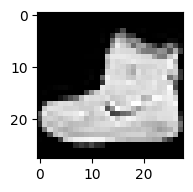

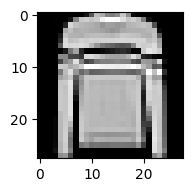

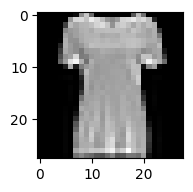

In [7]:
#plotting 
for i in range(3):  #we plot 10 images
    plt.subplot(1,3,1+i)   #2 rows, 5 cols, index of the image
    plt.imshow(x_train[i*5], cmap=plt.get_cmap('gray'))
    plt.show()


## Building the Generator Network

### Since the generator will up-sample the noise vector, we will use Conv2DTranspose module from Tensorflow. We create the network which performs the following transforms.

### Input the Noise (100X1) to a Dense Layer (7X7X256) followed by series of up-sampling layers Conv2DTranspose to reach the desired image size (28X28X1)

 

In [8]:
#Convert the train dataset into a 3D DATASET of stacked 3D images 
image_width = x_train.shape[1];
x_train = np.reshape(x_train, [-1, image_width ,image_width , 1]).astype('float32')


In [10]:
#Check the shape of the data now
x_train.shape


(60000, 28, 28, 1)

### We will now standardize the data values. Currently the range of values is from 0 to 255. We may either modify it to be between 0 and 1 or between -1 to 1. If we intend to use the tanh activation function in the last layer, we may use the range -1 to 1 or use the range 0 to 1 for sigmoid activation in the output layer
### Now, let use standardize the values

In [11]:
# Normalize the images to [-1, 1] [Normalized Value = (value - mean)/mean]
x_train = (x_train - 127.5) / 127.5  


In [12]:
#Generator Initializations
noise_length = 100


### We will use the Tensorflow functional API to build our network. By default the function considers a noise input size of 100, and image size of 28. Both parameters can be customized when the function is called.
### We manipulate the stride in order to increase the dimensions of the input from 7 to 28 and maniputate the filter count to downsize the output to 1 channel in the last layer.

In [13]:
def create_generator_model(image_size=28, noise_input=100):
   
   #Create input layer
   input_layer = tf.keras.layers.Input(shape=(noise_input,))
   
   #First upsampling to 7X7X256 
   #Increase dimensions and resize to 3D to feed it to Conv2DTranspose layer
   x = tf.keras.layers.Dense(7 * 7 * 256)(input_layer)
   x = tf.keras.layers.Reshape((7, 7, 256))(x)
   
   #Upscaling 1 : 128 filters, (2,2) stride
   #Input = 7X7X256
   #Output at this stage = 14X14X128
   #Syntax Note: kernel size can be specified as a tuple or integer or list
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=2, padding='same')(x)
   
   #Upscaling 2
   #Input = 14X14X128
   #Output at this stage = 28X28X64
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(64, kernel_size=[5,5], strides=2, padding='same')(x)
   
   #Upscaling 3
   #Input = 28X28X64
   #Output at this stage = 28X28X32
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(32, kernel_size=[5,5], strides=1, padding='same')(x)
   
   #Upscaling 3
   #Input = 28X28X32
   #Output at this stage = 28X28X1
   #Note that we use tanh activation and not Leaky Relu for the last layer. 
   x = tf.keras.layers.BatchNormalization()(x)
   x = tf.keras.layers.Activation('leaky_relu')(x)
   x = tf.keras.layers.Conv2DTranspose(1, kernel_size=[5,5], strides=1, padding='same')(x)
   
   x = tf.keras.layers.Activation('sigmoid')(x)
   #Create the model    
   gen_network = tf.keras.models.Model(input_layer, x, name='gen_network')
   
   return gen_network


In [14]:
def create_discriminator_model(desc_data=[28,28,1,]):
   
   #A typical Convolution  network for classification is built  
   disc_input = tf.keras.layers.Input(desc_data)
   #Input Dimension : 28X28X1
   #Output Dimension : 14X14X32
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(disc_input)
   x = tf.keras.layers.Conv2D(32, kernel_size=[5,5], strides=2, padding='same')(x)
   
   #Input Dimension : 14X14X32
   #Output Dimension : 7X7X64
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
   x = tf.keras.layers.Conv2D(64, kernel_size=[5,5], strides=2, padding='same')(x)
   
   #Input Dimension : 7X7X64
   #Output Dimension : 4X4X128
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
   x = tf.keras.layers.Conv2D(128, kernel_size=[5,5], strides=2, padding='same')(x)
   
   #Input Dimension : 4X4X128
   #Output Dimension : 4X4X256
   x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
   x = tf.keras.layers.Conv2D(256, kernel_size=[5,5], strides=1, padding='same')(x)
   
   #Input Dimension : Flattened(4X4X256)
   #Output Dimension : 1
   #Flatten the output and build an output layer
   x = tf.keras.layers.Flatten()(x)
   x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
   
   #Build Model
   disc_network = tf.keras.models.Model(disc_input, x, name='disc_network')
   
   return disc_network


2025-06-12 14:41:10.726873: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


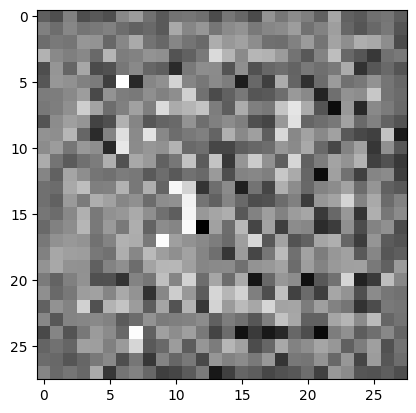

In [15]:
generator = create_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [16]:
#This code will check the functioning of the descriminator against a sample input. As of this point, 
#the descriminator is untrained.
discriminator = create_discriminator_model()
decision = discriminator(generated_image)
print (decision)


tf.Tensor([[0.4987488]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [18]:
def build_models():
   
   noise_size = 100
   lr = 2e-4
   decay = 6e-8
   
   #Build Base Discriminator model
   base_discriminator = create_discriminator_model(desc_data=(28,28,1,))
   
   #Define optimizer and compile model
   discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                         outputs=base_discriminator.outputs)
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)


   discriminator.compile(loss='binary_crossentropy',
                         optimizer=optimizer,
                         metrics=['accuracy'])
   
   #Build Generator model
   generator = create_generator_model(image_size=28, noise_input=noise_size)
   
   #Build Frozen Discriminator
   frozen_discriminator = tf.keras.models.Model(inputs=base_discriminator.inputs, 
                                         outputs=base_discriminator.outputs)
   #Freeze the weights of discriminator during adversarial training
   frozen_discriminator.trainable = False
   #Build Adversarial model
   optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

   #Adversarial = generator + discriminator
   adversarial = tf.keras.models.Model(generator.input, 
                       frozen_discriminator(generator.output))
   
   adversarial.compile(loss='binary_crossentropy',
                       optimizer=optimizer,
                       metrics=['accuracy'])    
   
   return generator, discriminator, adversarial


In [27]:
def train_gan(generator, discriminator, adversarial, noise_size=100, train_steps=2000, batch_size=32, preview_interval=200):
    import time
    import tensorflow as tf
    import numpy as np

    image_size = 28

    # Load Fashion MNIST dataset
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

    # Preprocess: reshape and normalize
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1]).astype('float32') / 255.0

    # Create test noise input for visual inspection
    test_noise_input = np.random.uniform(-1.0, 1.0, size=[16, noise_size])

    print(f"Starting training for {train_steps} steps with batch size {batch_size}...\n")
    start_time = time.time()

    for i in range(train_steps):
        # === Train Discriminator ===
        noise_input = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_size])
        fake_images = generator.predict(noise_input, verbose=0)

        real_images = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

        X = np.concatenate((real_images, fake_images))
        y_real = np.ones((batch_size, 1)) * 0.9

        y_fake = np.zeros((batch_size, 1))
        y = np.concatenate((y_real, y_fake))

        d_loss, d_acc = discriminator.train_on_batch(X, y)

        # === Train Adversarial (Generator through combined model) ===
        noise_input = np.random.uniform(-1.0, 1.0, size=[batch_size, noise_size])
        y_adv = np.ones((batch_size, 1))

        a_loss, a_acc = adversarial.train_on_batch(noise_input, y_adv)

        # Print status
        if i % 100 == 0:
            print(f"{i} [D loss: {d_loss:.6f}, acc: {d_acc:.6f}, A loss: {a_loss:.6f}, acc: {a_acc:.6f}]")

        # Save preview images
        if (i + 1) % preview_interval == 0:
            fake_images = generator.predict(test_noise_input, verbose=0)
            plot_images(fake_images, i + 1)

    elapsed = time.time() - start_time
    print(f"\nTraining completed in {elapsed:.2f} seconds.")

    # Save final generator model
    generator.save('fashionmnist_generator_dcgan_fast.h5')


In [20]:
def plot_images(fake_images, step):
   
   plt.figure(figsize=(2.5,2.5))
   num_images = fake_images.shape[0]
   
   image_size = fake_images.shape[1]
   rows = int(math.sqrt(fake_images.shape[0]))
   
   for i in range(num_images):
       plt.subplot(rows, rows, i + 1)
       image = np.reshape(fake_images[i], [image_size, image_size])
       plt.imshow(image, cmap='gray')
       plt.axis('off')
   plt.show()


In [21]:
G, D, A = build_models()


In [22]:
G.summary()


Model: "gen_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 1)           │             801 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,345,089 (8.95 MB)

 Trainable params: 2,344,129 (8.94 MB)

 Non-trainable params: 960 (3.75 KB)

In [23]:
A.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12544)               │       1,266,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 128)         │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 32)          │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 1)           │             801 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 1)                   │       1,080,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,425,666 (13.07 MB)

 Trainable params: 2,344,129 (8.94 MB)

 Non-trainable params: 1,081,537 (4.13 MB)

In [24]:
D.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 4, 4, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,080,577 (4.12 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,080,577 (4.12 MB)

Starting training for 2000 steps with batch size 32...

0 [D loss: 0.744679, acc: 0.267962, A loss: 0.574772, acc: 0.999812]
100 [D loss: 0.747714, acc: 0.267996, A loss: 0.572663, acc: 0.999832]


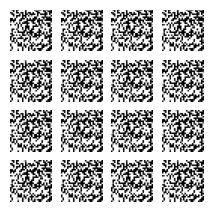

200 [D loss: 0.750175, acc: 0.268191, A loss: 0.570935, acc: 0.999848]
300 [D loss: 0.752207, acc: 0.269002, A loss: 0.569498, acc: 0.999862]


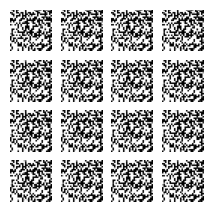

400 [D loss: 0.753926, acc: 0.268409, A loss: 0.568282, acc: 0.999873]
500 [D loss: 0.755389, acc: 0.268705, A loss: 0.567234, acc: 0.999882]


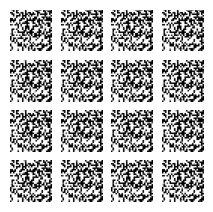

600 [D loss: 0.756654, acc: 0.269091, A loss: 0.566323, acc: 0.999891]
700 [D loss: 0.757763, acc: 0.268721, A loss: 0.565521, acc: 0.999898]


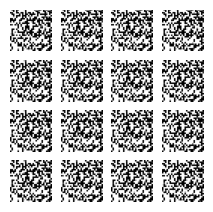

800 [D loss: 0.758745, acc: 0.268598, A loss: 0.564807, acc: 0.999904]
900 [D loss: 0.759613, acc: 0.269122, A loss: 0.564169, acc: 0.999910]


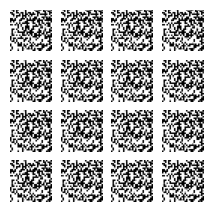

1000 [D loss: 0.760392, acc: 0.269179, A loss: 0.563596, acc: 0.999915]
1100 [D loss: 0.761092, acc: 0.269432, A loss: 0.563078, acc: 0.999919]


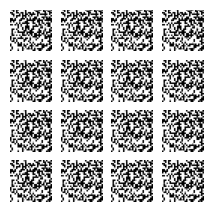

1200 [D loss: 0.761724, acc: 0.269614, A loss: 0.562610, acc: 0.999923]
1300 [D loss: 0.762302, acc: 0.269427, A loss: 0.562182, acc: 0.999927]


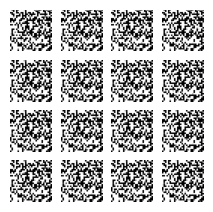

1400 [D loss: 0.762830, acc: 0.269431, A loss: 0.561785, acc: 0.999930]
1500 [D loss: 0.763319, acc: 0.269704, A loss: 0.561412, acc: 0.999933]


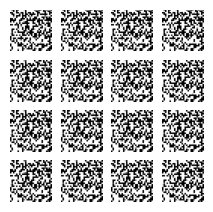

1600 [D loss: 0.763774, acc: 0.269581, A loss: 0.561065, acc: 0.999936]
1700 [D loss: 0.764194, acc: 0.269357, A loss: 0.560741, acc: 0.999938]


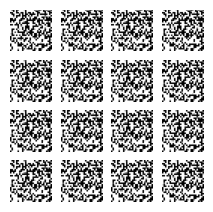

1800 [D loss: 0.764584, acc: 0.269346, A loss: 0.560441, acc: 0.999941]
1900 [D loss: 0.764944, acc: 0.269381, A loss: 0.560160, acc: 0.999943]


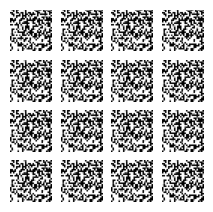


Training completed in 1154.19 seconds.


In [26]:
train_gan(G, D, A)


In [30]:
import glob
import imageio

anim_file = 'dcfashiongan.gif'

filenames = glob.glob(r'D:\Sups\Python\GAN\FASHION_mnist\*.png')
filenames = sorted(filenames)

with imageio.get_writer(anim_file, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
    # Append the last image again
    if filenames:
        last_image = imageio.imread(filenames[-1])
        writer.append_data(last_image)
